In [1]:
# Importing all the necessary packages
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import date

Loading Data

In [2]:
data = pd.read_csv ('https://sagemaker-studio-619837911586-g48c9o57oz5.s3.amazonaws.com/user_symptom.csv')
df_symptom = pd.DataFrame(data, columns= ['user_id','symptom_name','symptom_severity_score'])

data = pd.read_csv ('https://sagemaker-studio-619837911586-g48c9o57oz5.s3.amazonaws.com/user_onset_date.csv')
df_onset_date = pd.DataFrame(data, columns= ['user_id','first_definitive_diagnosis_date'])

data = pd.read_csv ('https://sagemaker-studio-619837911586-g48c9o57oz5.s3.amazonaws.com/user_ALSFRS_score.csv')
df_ALSFRS_score = pd.DataFrame(data, columns= ['user_id','report_date','score'])

Data Cleaning

In [3]:
# dropping null values from the dataset
df_symptom = df_symptom.dropna()

df_onset_date = df_onset_date.dropna()

df_ALSFRS_score = df_ALSFRS_score.dropna()

Data Analysis

In [4]:
df_onset_date.head()

,user_id,first_definitive_diagnosis_date
0,4941,2008-01-01
1,5814,2004-06-01
2,6161,2007-03-01
3,1702,2006-02-01
4,43,1999-08-01


In [5]:
df_symptom.head()

,user_id,symptom_name,symptom_severity_score
0,43943,TMJ (temporomandibular joint) pain,1.0
1,146585,atrophy of right hand muscles,4.0
2,146585,pain in right hand,1.0
3,146585,slow speech (bradyarthria),3.0
4,146585,stiffness in right leg,4.0


In [6]:
df_ALSFRS_score.head()

,user_id,report_date,score
0,2520,2005-08-05,36
1,2520,2002-01-04,44
2,2520,2006-12-08,28
3,2520,2006-08-04,29
4,2520,2007-04-13,29


Data Visualization

In [7]:
# Plot imports
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
sns.set_style('whitegrid')

%matplotlib inline

Example plot of ALSFRS from one user:

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


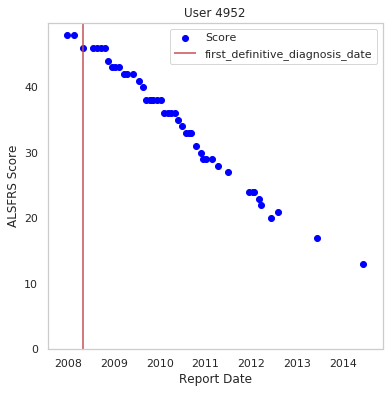

In [8]:
df = df_ALSFRS_score.iloc[list(np.where(df_ALSFRS_score['user_id']==4952)[0])]
df['report_date'] = pd.to_datetime(df['report_date'])
user_date = df_onset_date.iloc[list(np.where(df_onset_date['user_id']==4952)[0])].first_definitive_diagnosis_date
user_date = pd.to_datetime(user_date)

# Create figure and plot space
fig, ax = plt.subplots(figsize=(6, 6))

# Add x-axis and y-axis
ax.scatter(df['report_date'], df['score'], color='blue',label="Score")

# Set title and labels for axes
ax.set(xlabel="Report Date",
       ylabel="ALSFRS Score",
       title="User 4952")

ax.xaxis_date()
ax.grid(False)
ax.set_ylim(ymin=0)
ax.legend(loc="upper right")
plt.vlines(user_date,0,50, color='r', linestyle='-',label="first_definitive_diagnosis_date")
plt.legend(loc="upper right")
plt.show()

In the above graph we can observe how has the patient lost physical function over time and the vertical red line represents the first time the condition of patient reported. The above graph is plotted for the user 4952 and we can interpret it as the condition of the patient is getting worse from 2008 to 2014 as the number of pyhical function fails is increasing over the period of time.

Data Preparation

Calculating a mean for score to make it use able for the Regression Model

In [9]:
grouped_score = df_ALSFRS_score.groupby(['user_id'])['score'].mean().reset_index()
grouped_score

,user_id,score
0,43,14.687500
1,75,40.736842
2,108,27.333333
3,147,9.142857
4,163,21.692308
...,...,...
195,7318,39.187500
196,7326,40.200000
197,7344,25.074074
198,7423,45.000000


Calculating a mean for symptom_severity_score to make it predictable

In [10]:
grouped_severity_score = df_symptom.groupby(['user_id'])['symptom_severity_score'].mean().reset_index()
grouped_severity_score

,user_id,symptom_severity_score
0,2,2.583333
1,43,2.500000
2,45,2.875000
3,49,1.000000
4,50,2.500000
...,...,...
35907,438960,2.250000
35908,438967,1.000000
35909,438981,1.666667
35910,438995,3.000000


Calculating the number of days since the patient first reported the disease

In [11]:
df_onset_date['days_of_disease'] =  datetime.now().date() - pd.to_datetime(df_onset_date['first_definitive_diagnosis_date']).dt.date
df_onset_date

,user_id,first_definitive_diagnosis_date,days_of_disease
0,4941,2008-01-01,4606 days
1,5814,2004-06-01,5915 days
2,6161,2007-03-01,4912 days
3,1702,2006-02-01,5305 days
4,43,1999-08-01,7681 days
...,...,...,...
224,825,2010-01-01,3875 days
225,4031,2012-06-05,2989 days
226,1596,2015-08-06,1832 days
227,1752,2007-11-01,4667 days


Meraging the data from all the file to one

In [12]:
merged_outer = df_onset_date.merge(grouped_score, on='user_id', how='outer')
merged_outer

,user_id,first_definitive_diagnosis_date,days_of_disease,score
0,4941,2008-01-01,4606 days,35.388889
1,5814,2004-06-01,5915 days,23.923077
2,6161,2007-03-01,4912 days,32.217391
3,1702,2006-02-01,5305 days,25.576923
4,43,1999-08-01,7681 days,14.687500
...,...,...,...,...
241,6654,NaN,NaT,46.838710
242,6728,NaN,NaT,28.133333
243,6788,NaN,NaT,31.666667
244,7318,NaN,NaT,39.187500


In [13]:
Model_df = grouped_severity_score.merge(merged_outer, on='user_id', how='outer')   
Model_df

,user_id,symptom_severity_score,first_definitive_diagnosis_date,days_of_disease,score
0,2,2.583333,NaN,NaT,NaN
1,43,2.500000,1999-08-01,7681 days,14.687500
2,45,2.875000,NaN,NaT,NaN
3,49,1.000000,NaN,NaT,NaN
4,50,2.500000,NaN,NaT,NaN
...,...,...,...,...,...
36134,5993,NaN,NaN,NaT,43.967742
36135,6654,NaN,NaN,NaT,46.838710
36136,6728,NaN,NaN,NaT,28.133333
36137,7318,NaN,NaN,NaT,39.187500


In [14]:
Model_df.to_csv('analysis_data.csv',sep=',')

Uploading the result to the S3 Bucket

In [15]:
import boto3
import sagemaker
bucket='sagemaker-studio-619837911586-g48c9o57oz5' # Replace with your s3 bucket name
prefix = 'sagemaker' # Used as part of the path in the bucket where you store data
sess = sagemaker.Session()
url = sess.upload_data(path="analysis_data.csv",bucket=bucket,key_prefix=prefix)
url

's3://sagemaker-studio-619837911586-g48c9o57oz5/sagemaker/analysis_data.csv'

Prediction using the AutoML Regression Model

In [22]:
ep_name = 'Testing-plm'

In [23]:
import boto3, sys
sm_rt = boto3.Session().client('runtime.sagemaker')    

In [26]:
tp = tn = fp = fn = count = 0.5

with open('analysis_data.csv') as f:
    lines = f.readlines()
    for l in lines[1:]:   # Skip header
        l = l.split(',')  # Split CSV line into features
        label = l[-1]     # Store label
        l = l[:-1]        # Remove label
        l = ','.join(l)   # Rebuild CSV line without label
                
        response = sm_rt.invoke_endpoint(EndpointName=ep_name, ContentType='text/csv', Accept='text/csv', Body=l)

        response = response['Body'].read().decode("utf-8")
        #print("label %s response %s" %(label,response))
        
        if 'yes' in label:
            # Sample is positive
            if 'yes' in response:
                # True positive
                tp=tp+1
            else:
                # False negative
                fn=fn+1
        else:
            # Sample is negative
            if 'no' in response:
                # True negative
                tn=tn+1
            else:
                # False positive
                fp=fp+1
        count = count+1
        if (count % 100 == 0):   
            sys.stdout.write(str(count)+' ')
            
print ("Done")

In [25]:
print ("%d %d" % (tn, fp))
print ("%d %d" % (fn, tp))

accuracy  = (tp+tn)/(tp+tn+fp+fn)
precision = tp/(tp+fp)
recall    = tn/(tp+fn)
f1        = (2*precision*recall)/(precision+recall)

print ("%.4f %.4f %.4f %.4f" % (accuracy, precision, recall, f1))

0 0
0 0
0.5000 0.5000 0.5000 0.5000
